In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from scipy.stats import entropy
from google.colab import drive

In [4]:
drive.mount('/content/gdrive')
pune_df = pd.read_csv('/content/gdrive/MyDrive/Indian_housing_Pune_data.csv')

Mounted at /content/gdrive


In [5]:
q3 = pune_df["price"].quantile(0.75)
pune_df = pune_df[pune_df['price'] <= 2 * q3]

In [6]:
X = pune_df.copy()
y = X.pop('price')

In [7]:
cat_cols = ['house_type', 'location', 'city', 'currency', 'verificationDate', 'description', 'SecurityDeposit', 'Status']
num_cols = ['house_size', 'latitude', 'longitude', 'numBathrooms', 'numBalconies', 'pricesqft']

for col in num_cols:
    if col in X.columns:
        X[col] = X[col].replace({'\$': '', ',': '', ' sq ft': ''}, regex=True)
        X[col] = pd.to_numeric(X[col], errors='coerce')

In [8]:
le_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    unique_values = pd.concat([X[col]]).unique().astype(str)
    le.fit(unique_values)
    X[col] = le.transform(X[col].astype(str))
    le_dict[col] = le
    print(f"{col} mappings: {dict(zip(le.classes_, range(len(le.classes_))))}")

house_type mappings: {'1 BHK Apartment ': 0, '1 BHK Independent Floor ': 1, '1 BHK Independent House ': 2, '1 BHK Villa ': 3, '1 RK Studio Apartment ': 4, '2 BHK Apartment ': 5, '2 BHK Independent Floor ': 6, '2 BHK Independent House ': 7, '2 BHK Villa ': 8, '3 BHK Apartment ': 9, '3 BHK Independent Floor ': 10, '3 BHK Independent House ': 11, '3 BHK Villa ': 12, '4 BHK Apartment ': 13, '4 BHK Independent Floor ': 14, '4 BHK Independent House ': 15, '4 BHK Villa ': 16, '5 BHK Independent House ': 17, '5 BHK Villa ': 18}
location mappings: {' Kharadi': 0, 'Agalambe': 1, 'Akurdi': 2, 'Alandi': 3, 'Ambegaon Budruk': 4, 'Ambegaon Pathar': 5, 'Anand Nagar': 6, 'Aundh': 7, 'Aundh Gaon': 8, 'B T Kawde Road': 9, 'BT Kawde': 10, 'Bakhori': 11, 'Balewadi': 12, 'Balewadi High Street': 13, 'Baner': 14, 'Baner Pashan Link Road': 15, 'Baner Road': 16, 'Baramati': 17, 'Bavdhan': 18, 'Bhairav Nagar': 19, 'Bharati Vidyapeeth Campus': 20, 'Bhelkenagar': 21, 'Bhosari': 22, 'Bhugaon': 23, 'Bhukum': 24, 'B

In [9]:
num_imputer = SimpleImputer(strategy='mean')
X[num_cols] = num_imputer.fit_transform(X[num_cols])

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=13)

In [12]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

RandomForestRegressor()

In [25]:
rf_pred = rf_model.predict(X_test)
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_r2 = r2_score(y_test, rf_pred)

print(f"Random Forest - Mean absolute error: {rf_mae}")
print(f"Random Forest - Root mean squared error: {rf_rmse}")
print(f"Random Forest - Mean r squared score: {rf_r2}")

Random Forest - Mean absolute error: 2422.6247027741083
Random Forest - Root mean squared error: 3739.918862162986
Random Forest - Mean r squared score: 0.8222154545779987


In [13]:
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(random_state=42)

In [27]:
gb_pred = gb_model.predict(X_test)
gb_mae = mean_absolute_error(y_test, gb_pred)
gb_rmse = np.sqrt(mean_squared_error(y_test, gb_pred))
gb_r2 = r2_score(y_test, gb_pred)

print(f"Gradient Boosting - Mean absolute error: {gb_mae}")
print(f"Gradient Boosting - Root mean squared error: {gb_rmse}")
print(f"Gradient Boosting - Mean r squared score: {gb_r2}")

Gradient Boosting - Mean absolute error: 2647.6241053647555
Gradient Boosting - Root mean squared error: 3741.398923522064
Gradient Boosting - Mean r squared score: 0.8220747113627226


In [14]:
def predict_price(input_data):
    input_data_encoded = input_data.copy()

    for col in cat_cols:
        if col in input_data_encoded.columns:
            if input_data_encoded[col].dtype == object:
                input_data_encoded[col] = input_data_encoded[col].astype(str)
                if input_data_encoded[col].isin(le_dict[col].classes_).any():
                    input_data_encoded[col] = le_dict[col].transform(input_data_encoded[col])
                else:
                    print(f"Warning: Unseen labels detected in '{col}'.")

    for col in num_cols:
        if col in input_data_encoded.columns:
            input_data_encoded[col] = input_data_encoded[col].replace({'\$': '', ',': '', ' sq ft': ''}, regex=True)
            input_data_encoded[col] = pd.to_numeric(input_data_encoded[col], errors='coerce')
    input_data_encoded[num_cols] = num_imputer.transform(input_data_encoded[num_cols])
    missing_cols = set(cat_cols + num_cols) - set(input_data_encoded.columns)
    if missing_cols:
        raise ValueError(f"Missing columns for prediction: {missing_cols}")

    rf_prediction = rf_model.predict(input_data_encoded)
    gb_prediction = gb_model.predict(input_data_encoded)

    return rf_prediction, gb_prediction

In [32]:
def get_user_input():
    user_input = {
        'house_type': input("Enter house type (e.g., Apartment, Villa): "),
        'house_size': input("Enter house size (e.g., 1180 sq ft): "),
        'location': input("Enter location: "),
        'city': input("Enter city: "),
        'latitude': float(input("Enter latitude: ")),
        'longitude': float(input("Enter longitude: ")),
        'currency': input("Enter currency (e.g., INR): "),
        'numBathrooms': int(input("Enter number of bathrooms: ")),
        'numBalconies': int(input("Enter number of balconies: ")),
        'pricesqft': float(input("Enter price per sqft: ")),
        'verificationDate': input("Enter verification date): "),
        'description': input("Enter description: "),
        'SecurityDeposit': input("Enter security deposit: "),
        'Status': input("Enter status (e.g., Furnished/Unfurnished/Semi-furnished): ")
    }

    return pd.DataFrame([user_input])

new_data = get_user_input()
try:
    rf_pred, gb_pred = predict_price(new_data)
    print(f"Random Forest Prediction: {rf_pred[0]}")
    print(f"Gradient Boosting Prediction: {gb_pred[0]}")
except ValueError as e:
    print(e)

Enter house type (e.g., Apartment, Villa): 5
Enter house size (e.g., 1180 sq ft): 906 sq ft
Enter location: Lohegaon
Enter city: Pune
Enter latitude: 18.75420
Enter longitude: 13.2485
Enter currency (e.g., INR): INR
Enter number of bathrooms: 2
Enter number of balconies: 0
Enter price per sqft: 7253
Enter verification date): Posted 3 years ago
Enter description: 0
Enter security deposit: No Deposit
Enter status (e.g., Furnished/Unfurnished/Semi-furnished): Unfurnished
Random Forest Prediction: 14480.8
Gradient Boosting Prediction: 12788.163220954613


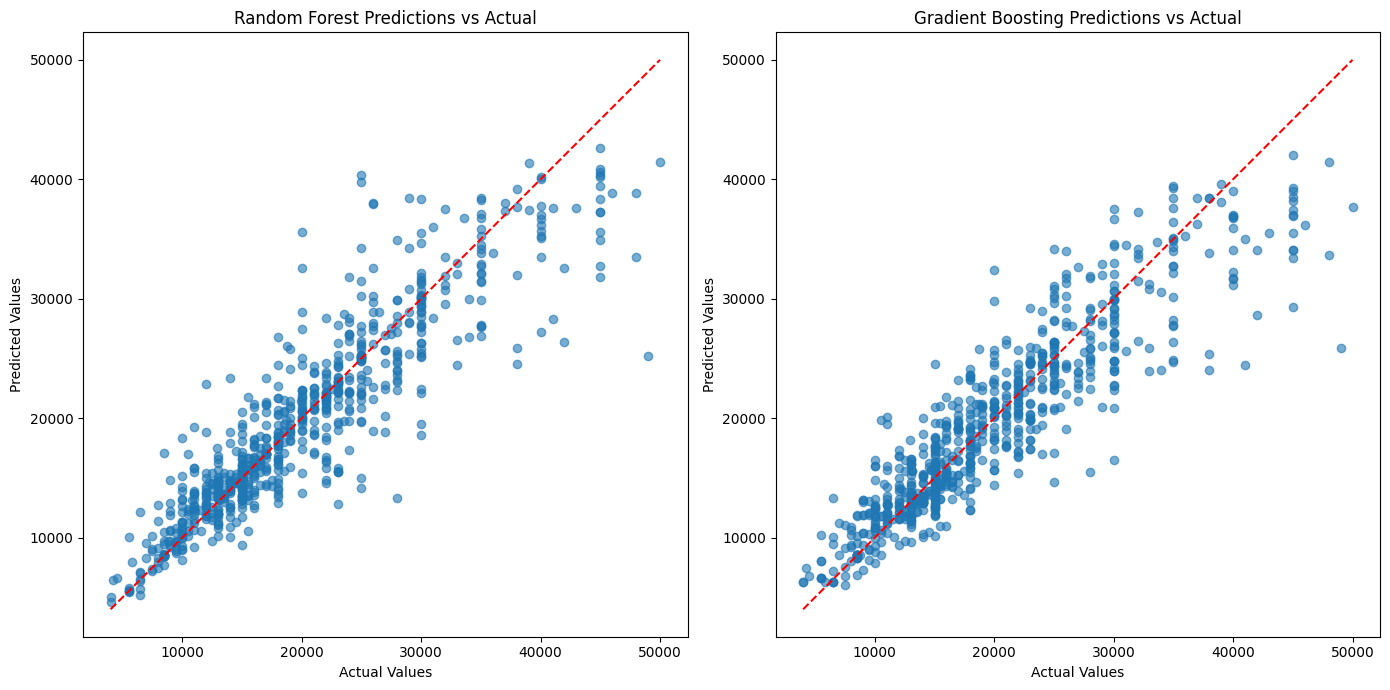

In [17]:
rf_pred = rf_model.predict(X_test).flatten()
gb_pred = gb_model.predict(X_test).flatten()
results_df = pd.DataFrame({
    'Actual': y_test.values,
    'Random Forest Prediction': rf_pred,
    'Gradient Boosting Prediction': gb_pred
})
plt.figure(figsize=(14, 7))

# Plot actual vs predicted for Random Forest
plt.subplot(1, 2, 1)
plt.scatter(results_df['Actual'], results_df['Random Forest Prediction'], alpha=0.6)
plt.plot([results_df['Actual'].min(), results_df['Actual'].max()],
         [results_df['Actual'].min(), results_df['Actual'].max()], 'r--')
plt.title('Random Forest Predictions vs Actual')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# Plot actual vs predicted for Gradient Boosting
plt.subplot(1, 2, 2)
plt.scatter(results_df['Actual'], results_df['Gradient Boosting Prediction'], alpha=0.6)
plt.plot([results_df['Actual'].min(), results_df['Actual'].max()],
         [results_df['Actual'].min(), results_df['Actual'].max()], 'r--')
plt.title('Gradient Boosting Predictions vs Actual')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

plt.tight_layout()
plt.show()

In [19]:
rf_errors = y_test - rf_pred
gb_errors = y_test - gb_pred

# Calculate probability distributions
rf_hist, rf_bins = np.histogram(rf_errors, bins=30, density=True)
gb_hist, gb_bins = np.histogram(gb_errors, bins=30, density=True)

# Avoid division by zero in KL divergence calculation
rf_hist += 1e-10
gb_hist += 1e-10

# Calculate KL divergence
kl_rf_to_gb = entropy(rf_hist, gb_hist)
kl_gb_to_rf = entropy(gb_hist, rf_hist)

print(f"KL Divergence (Random Forest || Gradient Boosting): {kl_rf_to_gb}")
print(f"KL Divergence (Gradient Boosting || Random Forest): {kl_gb_to_rf}")

KL Divergence (Random Forest || Gradient Boosting): 0.24580869484687765
KL Divergence (Gradient Boosting || Random Forest): 0.29188261844864377


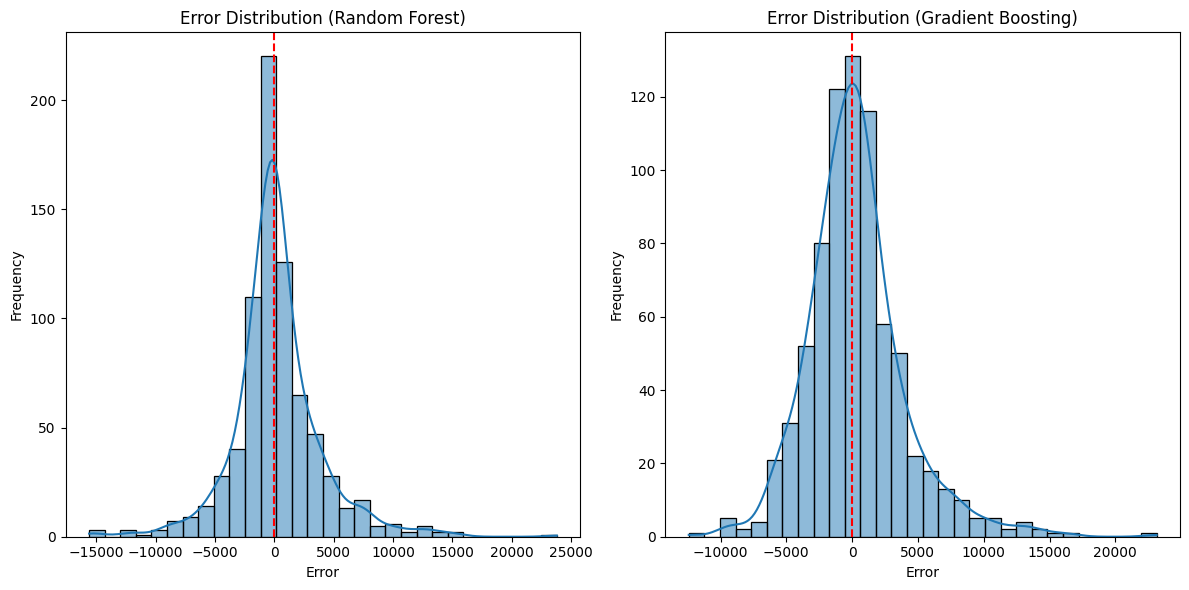

In [22]:
# Plotting error distribution for Random Forest
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(rf_errors, bins=30, kde=True)
plt.axvline(0, color='red', linestyle='--')
plt.title('Error Distribution (Random Forest)')
plt.xlabel('Error')
plt.ylabel('Frequency')

# Plotting error distribution for Gradient Boosting
plt.subplot(1, 2, 2)
sns.histplot(gb_errors, bins=30, kde=True)
plt.axvline(0, color='red', linestyle='--')
plt.title('Error Distribution (Gradient Boosting)')
plt.xlabel('Error')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()